# LifeSnaps Preprocessing Experiments

#### Import de llibreries necessaries

In [8]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('../data/df_cleaned.csv')

print(f"Shape: {df.shape}")

Shape: (7410, 25)


## Lectura de dades i split de train / test

In [9]:
# Comprovem quina es les estructura de les nostres dades faltants en el target
TARGETS = ['TENSE/ANXIOUS', 'TIRED']
df_complete = df.dropna(subset=TARGETS)

df_null_targets = df[df["TENSE/ANXIOUS"].isnull() | df["TIRED"].isnull()]

print(f"Estructura dades amb target:\n{df_complete.shape}")
print(f"Estructura dades target null:\n{df_null_targets.shape}")

Estructura dades amb target:
(2290, 25)
Estructura dades target null:
(5120, 25)


In [10]:
# Difinim X i els targets y
# Prediccio de TENSE/ANXIOUS i TIRED
X = df_complete.drop(columns=TARGETS)
y_tense = df_complete['TENSE/ANXIOUS']
y_tired = df_complete['TIRED']

numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

print(f"\nCol. numeriques ({len(numerical_features)}): \n{numerical_features}")
print(f"Col. categoriques ({len(categorical_features)}): \n{categorical_features}")




Col. numeriques (20): 
['nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'daily_temperature_variation', 'calories', 'bpm', 'sedentary_minutes', 'resting_hr', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'bmi']
Col. categoriques (3): 
['age', 'gender', 'bmi_tipo']


### Train / Test Split

In [103]:
# Estratifiquem respecte un dels targets per tal d'assegurar el bon split
train_idx, test_idx = train_test_split(df_complete.index,test_size=0.20, random_state=42,stratify=y_tense)

X_train, X_test = X.loc[train_idx], X.loc[test_idx]

y_tense_train, y_tense_test = y_tense.loc[train_idx], y_tense.loc[test_idx]

y_tired_train, y_tired_test = y_tired.loc[train_idx], y_tired.loc[test_idx]

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print('\n','--'*50)
print(f"\nDistribució train:\n{y_tense_train.value_counts(normalize=True)}")
print(f"\nDistribució test:\n{y_tense_test.value_counts(normalize=True)}")
print('\n','--'*50)
print(f"\nDistribució train:\n{y_tired_train.value_counts(normalize=True)}")
print(f"\nDistribució test:\n{y_tired_test.value_counts(normalize=True)}")


Train shape: (1832, 23)
Test shape: (458, 23)

 ----------------------------------------------------------------------------------------------------

Distribució train:
TENSE/ANXIOUS
0.0    0.780022
1.0    0.219978
Name: proportion, dtype: float64

Distribució test:
TENSE/ANXIOUS
0.0    0.779476
1.0    0.220524
Name: proportion, dtype: float64

 ----------------------------------------------------------------------------------------------------

Distribució train:
TIRED
0.0    0.623362
1.0    0.376638
Name: proportion, dtype: float64

Distribució test:
TIRED
0.0    0.585153
1.0    0.414847
Name: proportion, dtype: float64


### Preprocessador utilitzat inicial

In [45]:
# Passos de preprocessament
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)])


### Classifiers i Grids que utilitzarem

In [20]:
# Define classifiers
CLASSIFIERS = {
    "MLP": MLPClassifier(random_state=42, max_iter=500),
    "SVM": SVC(random_state=42, probability=True),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Param grids pel GridSearchCV
# Complexitat reduida per tal que no porti un temps exegerat de execució
# Un cop trobem el model bó podrem augmenter la complexitat del model
PARAM_GRIDS = {
    "MLP": {
        "classifier__hidden_layer_sizes": [(100,), (100, 50)],
        "classifier__alpha": [1e-4, 1e-3, 1e-2],

    },
    "SVM": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["rbf"], # Si hi ha bons resultats provar d'altres
        "classifier__gamma": ["scale", "auto", 0.01]
    },
    "RandomForest": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 10, 20],
        "classifier__class_weight": ["balanced", "balanced_subsample"]
    },
    "GradientBoosting": {
        "classifier__n_estimators": [200, 400],
        "classifier__learning_rate": [0.05, 0.1],
        "classifier__max_depth": [3, 5]
    }
}

## ENTRENAMENT DEL MODEL BASE

In [58]:
f1_cls1 = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

TARGETS_SPLIT = {
    "TENSE/ANXIOUS": (y_tense_train, y_tense_test),
    "TIRED":         (y_tired_train, y_tired_test)
}
# Observem de forma visual la matriu de confusió dels millors models segons el f1
TARGETS_TEST = {
    "TENSE/ANXIOUS": y_tense_test,
    "TIRED":         y_tired_test
}

In [46]:
base_results = []
base_models = {}

for target, (y_train, y_test) in TARGETS_SPLIT.items():
    print(f"\n=== {target} ===")
    base_models[target] = {}

    for model, classifier in CLASSIFIERS.items():
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", SMOTE(random_state=42)),
            ("classifier", classifier)
        ])

        gs = GridSearchCV(
            estimator=pipeline,
            param_grid=PARAM_GRIDS[model],
            scoring=f1_cls1,
            cv=cv,
            n_jobs=-1,
            refit=True
        )
        gs.fit(X_train, y_train)


        best = gs.best_estimator_
        base_models[target][model] = best
        
        y_pred = best.predict(X_test)

        report = classification_report(
            y_test,
            y_pred, # Fem un predict amb el millor model trobat i comparem
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )

        f1_cl1_test = report["1"]["f1-score"]

        base_results.append({
            "Target":                target,
            "Experiment":            "Entrenament basic",
            "Model":                 model,
            "Best Params":           gs.best_params_,
            "Best CV F1 (clase 1)":  gs.best_score_,
            "Test Precision (1)":    report["1"]["precision"],
            "Test Recall (1)":       report["1"]["recall"],
            "Test F1 (1)":           f1_cl1_test,
            "Test F1 (macro global)": f1_score(y_test, best.predict(X_test), average="macro")
        })

        print(f"{model:20s} | Best CV F1(cl1): {gs.best_score_:.4f} | "
              f"Test F1(cl1): {f1_cl1_test:.4f}")


=== Entrenament per: TENSE/ANXIOUS ===
MLP                  | Best CV F1(cl1): 0.3436 | Test F1(cl1): 0.2723
SVM                  | Best CV F1(cl1): 0.3594 | Test F1(cl1): 0.3401
RandomForest         | Best CV F1(cl1): 0.3606 | Test F1(cl1): 0.4239
GradientBoosting     | Best CV F1(cl1): 0.3434 | Test F1(cl1): 0.3663

=== Entrenament per: TIRED ===
MLP                  | Best CV F1(cl1): 0.4546 | Test F1(cl1): 0.5508
SVM                  | Best CV F1(cl1): 0.4737 | Test F1(cl1): 0.5366
RandomForest         | Best CV F1(cl1): 0.4674 | Test F1(cl1): 0.4809
GradientBoosting     | Best CV F1(cl1): 0.4427 | Test F1(cl1): 0.5561


In [47]:
# Convertim en un DataFrame
base_results_df = pd.DataFrame(base_results)

display_cols = ["Target","Experiment","Model","Best CV F1 (clase 1)","Test F1 (1)","Test F1 (macro global)"]

display(base_results_df[display_cols].round(4))


,Target,Experiment,Model,Best CV F1 (clase 1),Test F1 (1),Test F1 (macro global)
0,TENSE/ANXIOUS,Entrenament basic,MLP,0.3436,0.2723,0.5259
1,TENSE/ANXIOUS,Entrenament basic,SVM,0.3594,0.3401,0.5141
2,TENSE/ANXIOUS,Entrenament basic,RandomForest,0.3606,0.4239,0.6396
3,TENSE/ANXIOUS,Entrenament basic,GradientBoosting,0.3434,0.3663,0.5935
4,TIRED,Entrenament basic,MLP,0.4546,0.5508,0.6204
5,TIRED,Entrenament basic,SVM,0.4737,0.5366,0.5805
6,TIRED,Entrenament basic,RandomForest,0.4674,0.4809,0.5866
7,TIRED,Entrenament basic,GradientBoosting,0.4427,0.5561,0.6249


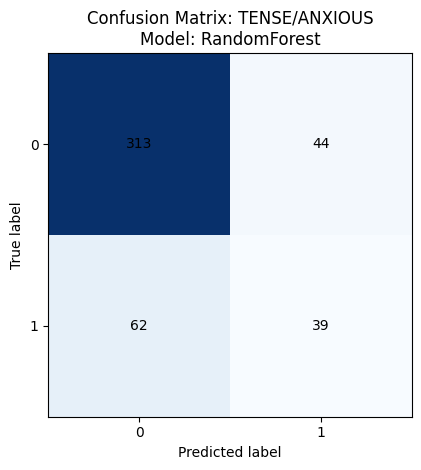

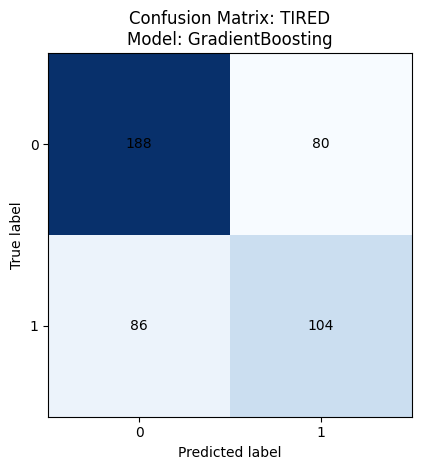

In [48]:


for target, y_test in TARGETS_TEST.items():
    # Seleccionem els millor model segons f1 de la classe 1 
    df_t = base_results_df[base_results_df["Target"] == target]
    best_f1 = df_t["Test F1 (1)"].idxmax()

    best_model_name = df_t.loc[best_f1, "Model"]
    best_model = base_models[target][best_model_name]
    
    # Predict and compute confusion matrix
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f"Confusion Matrix: {target}\nModel: {best_model_name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    tick_marks = [0, 1]
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    
    # Annotate each cell with the count
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    
    plt.tight_layout()
    plt.show()

## EXPERIMENT 1: Importancia de les caracteristiques

Entrenem RandomForest per indentificar les caracteristiques més importants (10-15), posteriorment entrenem els models utilitzant aquestes 10-15 característiques, per veure si augmenta el rendiment del model. Proavarem tambe amb permutation importances.

### Feature Importance

La Gini importance d’una feature és: La suma de totes les reduccions d’impuresa (Gini) que ha causat al llarg de tots els arbres i de totes les seves aparicions.


=== TENSE/ANXIOUS ===
  millors paràmetres: {'clf__max_depth': 15, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
  CV F1(clase=1):     0.3741
  Test F1(clase=1):  0.3614

=== TIRED ===
  millors paràmetres: {'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
  CV F1(clase=1):     0.4778
  Test F1(clase=1):  0.5341


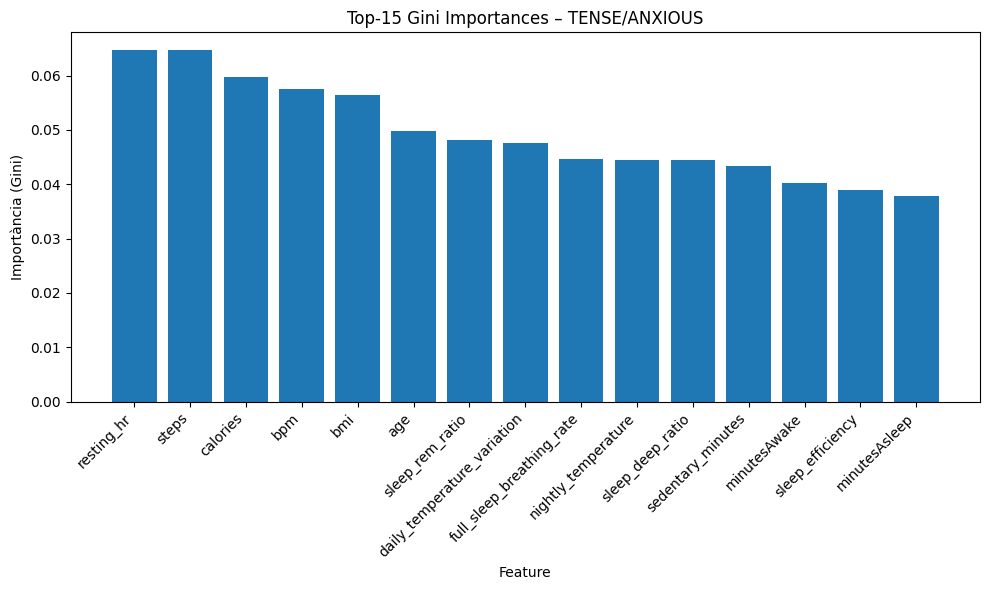

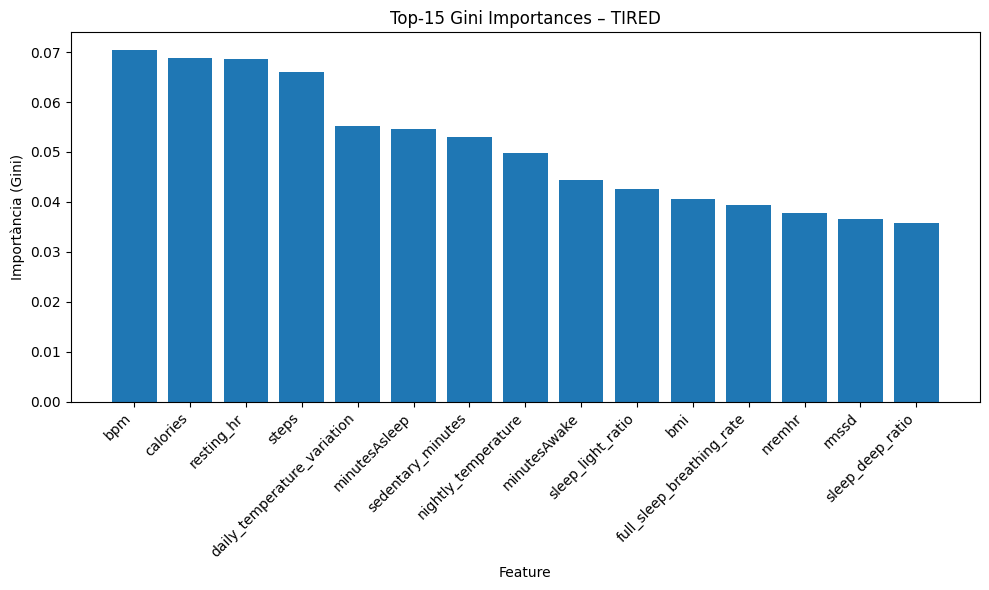


F1-score (classe 1) en test set:
  TENSE/ANXIOUS  : 0.3614
  TIRED          : 0.5341

Top-features dict a punt:
  TENSE/ANXIOUS: Top-10 = ['resting_hr', 'steps', 'calories', 'bpm', 'bmi', 'age', 'sleep_rem_ratio', 'daily_temperature_variation', 'full_sleep_breathing_rate', 'nightly_temperature']
  TIRED: Top-10 = ['bpm', 'calories', 'resting_hr', 'steps', 'daily_temperature_variation', 'minutesAsleep', 'sedentary_minutes', 'nightly_temperature', 'minutesAwake', 'sleep_light_ratio']


In [ ]:
# -----------------------------------------------
# 1. Param grid & pipeline bàsic
# -----------------------------------------------
param_grid_rf = {
    "clf__n_estimators":      [100, 200, 300],
    "clf__max_depth":         [None, 15, 30],
    "clf__min_samples_split": [2, 4, 8],
    "clf__min_samples_leaf":  [1, 2, 4]
}

base_pipe_rf = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote",        SMOTE(random_state=42)),
    ("clf",          RandomForestClassifier(
                         class_weight="balanced",
                         random_state=42,
                         n_jobs=-1))
])

# -----------------------------------------------
# 2. Entrenament, importàncies i emmagatzematge
# -----------------------------------------------
best_rf_models        = {}
aggregated_importances = {}   # {target: Series(importance)}
f1_results            = {}   # {target: f1_test}

for target, (y_train, y_test) in TARGETS_SPLIT.items():
    print(f"\n=== {target} ===")
    
    # Grid Search (clone intern automàtic de scikit‑learn)
    gs = GridSearchCV(
        base_pipe_rf,
        param_grid_rf,
        scoring=f1_cls1,
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    
    best_model = gs.best_estimator_
    best_rf_models[target] = best_model
    
    print("  millors paràmetres:", gs.best_params_)
    print("  CV F1(clase=1):    ", round(gs.best_score_, 4))
    
    # ---------- noms de columnes ----------
    cat_pipe = best_model.named_steps["preprocessor"].named_transformers_["cat"]
    ohe      = cat_pipe.named_steps.get("onehot") or cat_pipe.named_steps.get("encode")
    ohe_names = ohe.get_feature_names_out(categorical_features)
    all_features = numerical_features + list(ohe_names)
    
    # ---------- importàncies Gini ----------
    gini_raw = pd.Series(
        best_model.named_steps["clf"].feature_importances_,
        index=all_features
    )
    
    # Agrupació de dummies
    agg = {num: gini_raw.get(num, 0.0) for num in numerical_features}
    for cat in categorical_features:
        agg[cat] = gini_raw[[c for c in gini_raw.index if c.startswith(f"{cat}_")]].sum()
    
    aggregated_importances[target] = pd.Series(agg).sort_values(ascending=False)
    
    # ---------- mètrica test ----------
    y_pred   = best_model.predict(X_test)
    f1_test  = f1_score(y_test, y_pred, pos_label=1)
    f1_results[target] = round(f1_test, 4)
    print(f"  Test F1(clase=1):  {f1_test:.4f}")

# -----------------------------------------------
# 3. Top‑10 / Top‑15 per target
# -----------------------------------------------
top_features = {
    target: {
        10: imp.head(10).index.tolist(),
        15: imp.head(15).index.tolist()
    }
    for target, imp in aggregated_importances.items()
}

# -----------------------------------------------
# 4. Visualització de les Top‑15 importàncies
# -----------------------------------------------
for target, imp_ser in aggregated_importances.items():
    plt.figure(figsize=(10, 6))
    top15 = imp_ser.head(15)
    plt.bar(top15.index, top15.values)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top-15 Gini Importances - {target}")
    plt.xlabel("Feature")
    plt.ylabel("Importància (Gini)")
    plt.tight_layout()
    plt.show()

### Rentrenament de models 10-15 millors features

In [ ]:
# --- Retraining with Top Features ---

fi_results = []
fi_models = {}

for target, (y_train, y_test) in TARGETS_SPLIT.items():
    print(f"\n=== {target} ===")
    fi_models[target] = {}


    for k in [10, 15]:
        print(f"\n-- Using Top {k} Features --")
        fi_models[target][k] = {}
        current_top_features = top_features[target][k]
        top_num_features = [f for f in current_top_features if f in numerical_features]
        top_cat_features = [f for f in current_top_features if f in categorical_features]
        print(f"Selected Numerical: {top_num_features}")
        print(f"Selected Categorical: {top_cat_features}")

        transformers = []

        if top_num_features: transformers.append(("num", numeric_transformer, top_num_features))
        if top_cat_features: transformers.append(("cat", categorical_transformer, top_cat_features))
        
        if not transformers: continue
        preprocessor_top_n = ColumnTransformer(transformers=transformers, remainder="drop")

        for model, classifier in CLASSIFIERS.items():
            pipeline = ImbPipeline([
                ("preprocessor", preprocessor_top_n),
                ("smote", SMOTE(random_state=42)),
                ("classifier", classifier)
            ])
            gs = GridSearchCV(
                pipeline, 
                PARAM_GRIDS[model], 
                scoring=f1_cls1,
                cv=cv, 
                n_jobs=-1
            )

            gs.fit(X_train, y_train)
            best_estimator = gs.best_estimator_
            fi_models[target][k][model] = best_estimator
            
            y_pred = best_estimator.predict(X_test)

            report = classification_report(
            y_test,
            y_pred, # Fem un predict amb el millor model trobat i comparem
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )

            f1_cl1_test = report["1"]["f1-score"]

            fi_results.append({
                "Target":                target,
                "Model":                 model,
                "Experiment":            f'Top_{k}_Features',
                "Best Params":           gs.best_params_,
                "Best CV F1 (clase 1)":  gs.best_score_,
                "Test Precision (1)":    report["1"]["precision"],
                "Test Recall (1)":       report["1"]["recall"],
                "Test F1 (1)":           f1_cl1_test,
                "Test F1 (macro global)": f1_score(y_test, best_estimator.predict(X_test), average="macro")
            })

            print(f"{model:20s} | Best CV F1(cl1): {gs.best_score_:.4f} | "
              f"Test F1(cl1): {f1_cl1_test:.4f}")




=== TENSE/ANXIOUS ===

-- Using Top 10 Features --
Selected Numerical: ['resting_hr', 'steps', 'calories', 'bpm', 'bmi', 'sleep_rem_ratio', 'daily_temperature_variation', 'full_sleep_breathing_rate', 'nightly_temperature']
Selected Categorical: ['age']
MLP                  | Best CV F1(cl1): 0.3750 | Test F1(cl1): 0.4196
SVM                  | Best CV F1(cl1): 0.4038 | Test F1(cl1): 0.4207
RandomForest         | Best CV F1(cl1): 0.3665 | Test F1(cl1): 0.4057
GradientBoosting     | Best CV F1(cl1): 0.3522 | Test F1(cl1): 0.4215

-- Using Top 15 Features --
Selected Numerical: ['resting_hr', 'steps', 'calories', 'bpm', 'bmi', 'sleep_rem_ratio', 'daily_temperature_variation', 'full_sleep_breathing_rate', 'nightly_temperature', 'sleep_deep_ratio', 'sedentary_minutes', 'minutesAwake', 'sleep_efficiency', 'minutesAsleep']
Selected Categorical: ['age']
MLP                  | Best CV F1(cl1): 0.3591 | Test F1(cl1): 0.2973
SVM                  | Best CV F1(cl1): 0.3775 | Test F1(cl1): 0.3653
R

In [65]:
feature_importance_results_df = pd.DataFrame(fi_results)

display(feature_importance_results_df[display_cols].round(4))

,Target,Experiment,Model,Best CV F1 (clase 1),Test F1 (1),Test F1 (macro global)
0,TENSE/ANXIOUS,Top_10_Features,MLP,0.3750,0.4196,0.4473
1,TENSE/ANXIOUS,Top_10_Features,SVM,0.4038,0.4207,0.4473
2,TENSE/ANXIOUS,Top_10_Features,RandomForest,0.3665,0.4057,0.4473
3,TENSE/ANXIOUS,Top_10_Features,GradientBoosting,0.3522,0.4215,0.4473
4,TENSE/ANXIOUS,Top_15_Features,MLP,0.3591,0.2973,0.4473
5,TENSE/ANXIOUS,Top_15_Features,SVM,0.3775,0.3653,0.4473
6,TENSE/ANXIOUS,Top_15_Features,RandomForest,0.3485,0.3961,0.4473
7,TENSE/ANXIOUS,Top_15_Features,GradientBoosting,0.3400,0.3349,0.4473
8,TIRED,Top_10_Features,MLP,0.4609,0.5063,0.6249
9,TIRED,Top_10_Features,SVM,0.4829,0.5354,0.6249


### Permutation Importance


=== Permutation importance: TENSE/ANXIOUS ===

Top-15 features (Permutation F1):


,importance
gender,0.020160
bmi,0.019796
spo2,0.018559
rmssd,0.013683
full_sleep_breathing_rate,0.013464
nightly_temperature,0.013464
nremhr,0.012955
daily_temperature_variation,0.009534
bmi_tipo,0.006914
sleep_deep_ratio,0.006696


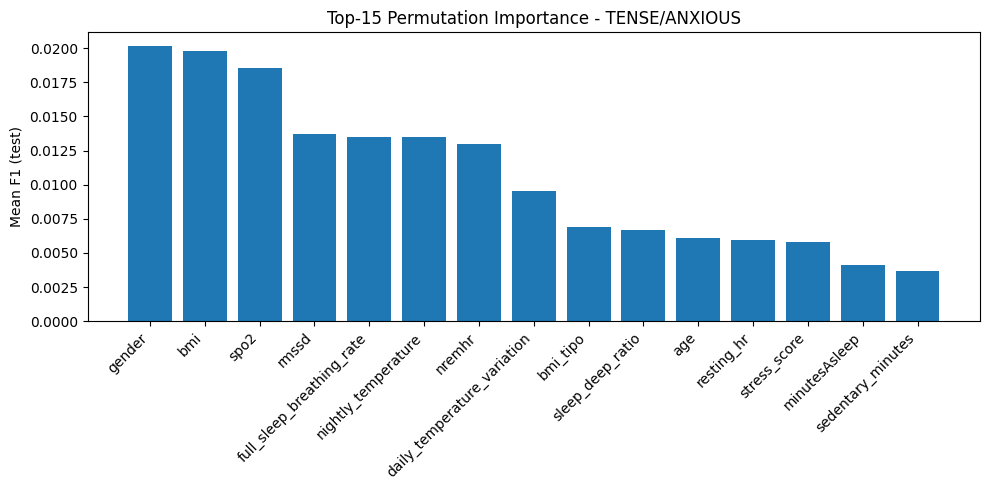


=== Permutation importance: TIRED ===

Top-15 features (Permutation F1):


,importance
bmi,0.019432
bmi_tipo,0.018559
calories,0.013537
sleep_wake_ratio,0.012591
minutesAsleep,0.011645
bpm,0.010917
steps,0.010553
minutesAwake,0.010480
sleep_rem_ratio,0.009753
full_sleep_breathing_rate,0.009170


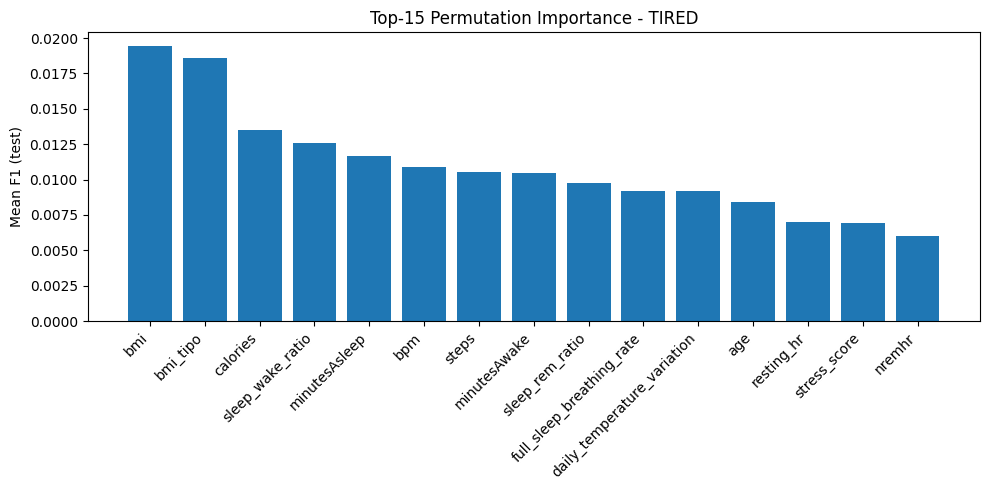

In [ ]:
perm_importances   = {}   # {target: Series}
perm_top_features  = {}   # {target: {10: [...], 15: [...]}}

for target, (y_train, y_test) in TARGETS_SPLIT.items():
    print(f"\n=== Permutation importance: {target} ===")
    
    best_model = best_rf_models[target]  # pipeline complet
    
    result = permutation_importance(
        best_model,
        X_test, y_test,
        n_repeats=30,
        n_jobs=-1,
        random_state=42
    )
    
    # 1) noms originals (no one‑hot)
    orig_features = numerical_features + categorical_features
    
    # 2) Sèrie d'importàncies alineada
    imp_ser = pd.Series(result.importances_mean,
                        index=orig_features).sort_values(ascending=False)
    
    # 3) guardar sèries i Top‑k
    perm_importances[target] = imp_ser
    perm_top_features[target] = {
        10: imp_ser.head(10).index.tolist(),
        15: imp_ser.head(15).index.tolist()
    }
    

    print("\nTop-15 features (Permutation F1):")
    display(imp_ser.head(15).to_frame("importance"))
    
    top15 = imp_ser.head(15)
    plt.figure(figsize=(10, 5))
    plt.bar(top15.index, top15.values)
    plt.title(f"Top-15 Permutation Importance - {target}")
    plt.ylabel("Mean F1 (test)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



### Reentrenament Permutation importance

In [ ]:
perm_topk_results  = []            
perm_topk_models   = {}               

for target, (y_train, y_test) in TARGETS_SPLIT.items():
    perm_topk_models[target] = {}
    for k in [10, 15]:
        sel_feats = perm_top_features[target][k]
        num_sel   = [f for f in sel_feats if f in numerical_features]
        cat_sel   = [f for f in sel_feats if f in categorical_features]
        
        # --- pre‑processador limitat als top‑k ---
        transformers = []
        if num_sel:
            transformers.append(("num", numeric_transformer, num_sel))
        if cat_sel:
            transformers.append(("cat", categorical_transformer, cat_sel))
        preproc_top = ColumnTransformer(transformers)
        
        perm_topk_models[target][k] = {}
        
        for model, classifier in CLASSIFIERS.items():
            print(f'== {target} ==')
            pipe = ImbPipeline([
                ("preprocessor", preproc_top),
                ("smote",        SMOTE(random_state=42)),
                ("classifier",   classifier)
            ])
            
            gs = GridSearchCV(
                pipe,
                PARAM_GRIDS[model],
                scoring=f1_cls1,
                cv=cv,
                n_jobs=-1
            )
            gs.fit(X_train, y_train)
            
            best_est = gs.best_estimator_
            perm_topk_models[target][k][model] = best_est
            
            y_pred  = best_est.predict(X_test)
            cv_f1   = gs.best_score_
            
            report = classification_report(
            y_test,
            y_pred, # Fem un predict amb el millor model trobat i comparem
            labels=[0, 1],
            output_dict=True,
            zero_division=0
            )
            f1_cl1_test = report["1"]["f1-score"]
            macro_f1     = f1_score(y_test, y_pred, average="macro")

            perm_topk_results.append({
                "Target":                target,
                "Experiment":            f"Top_{k}_Permutation",
                "Model":                 model,
                "Best Params":           gs.best_params_,
                "Best CV F1 (clase 1)":  gs.best_score_,
                "Test Precision (1)":    report["1"]["precision"],
                "Test Recall (1)":       report["1"]["recall"],
                "Test F1 (1)":           f1_cl1_test,
                "Test F1 (macro global)":       macro_f1

            })
            
            print(f"{model:20s} | Best CV F1(cl1): {gs.best_score_:.4f} | "
              f"Test F1(cl1): {f1_cl1_test:.4f}")



MLP                  | Best CV F1(cl1): 0.3547 | Test F1(cl1): 0.3769
SVM                  | Best CV F1(cl1): 0.3743 | Test F1(cl1): 0.4183
RandomForest         | Best CV F1(cl1): 0.3530 | Test F1(cl1): 0.4603
GradientBoosting     | Best CV F1(cl1): 0.3418 | Test F1(cl1): 0.4167
MLP                  | Best CV F1(cl1): 0.3729 | Test F1(cl1): 0.3596
SVM                  | Best CV F1(cl1): 0.3922 | Test F1(cl1): 0.4103
RandomForest         | Best CV F1(cl1): 0.3724 | Test F1(cl1): 0.4771
GradientBoosting     | Best CV F1(cl1): 0.3608 | Test F1(cl1): 0.4320
MLP                  | Best CV F1(cl1): 0.4498 | Test F1(cl1): 0.4802
SVM                  | Best CV F1(cl1): 0.4843 | Test F1(cl1): 0.5634
RandomForest         | Best CV F1(cl1): 0.4472 | Test F1(cl1): 0.5042
GradientBoosting     | Best CV F1(cl1): 0.4585 | Test F1(cl1): 0.5299
MLP                  | Best CV F1(cl1): 0.4628 | Test F1(cl1): 0.4426
SVM                  | Best CV F1(cl1): 0.4892 | Test F1(cl1): 0.5109
RandomForest        

In [79]:
perm_topk_results_df = pd.DataFrame(perm_topk_results)
display_cols_perm = ["Target","Experiment","Model","Best CV F1 (clase 1)","Test F1 (1)","Test F1 (macro)"] # m'he deixat global, canviar a la proxima
display(perm_topk_results_df[display_cols_perm].round(4))

,Target,Experiment,Model,Best CV F1 (clase 1),Test F1 (1),Test F1 (macro)
0,TENSE/ANXIOUS,Top_10_Permutation,MLP,0.3547,0.3769,0.5650
1,TENSE/ANXIOUS,Top_10_Permutation,SVM,0.3743,0.4183,0.5632
2,TENSE/ANXIOUS,Top_10_Permutation,RandomForest,0.3530,0.4603,0.6349
3,TENSE/ANXIOUS,Top_10_Permutation,GradientBoosting,0.3418,0.4167,0.6048
4,TENSE/ANXIOUS,Top_15_Permutation,MLP,0.3729,0.3596,0.5737
5,TENSE/ANXIOUS,Top_15_Permutation,SVM,0.3922,0.4103,0.5799
6,TENSE/ANXIOUS,Top_15_Permutation,RandomForest,0.3724,0.4771,0.6569
7,TENSE/ANXIOUS,Top_15_Permutation,GradientBoosting,0.3608,0.4320,0.6094
8,TIRED,Top_10_Permutation,MLP,0.4498,0.4802,0.5567
9,TIRED,Top_10_Permutation,SVM,0.4843,0.5634,0.5919


## EXPERIMENT 2: PCA


Es realitza una anàlisi de components principals (PCA) per examinar com evolucionen els components més rellevants del conjunt de dades en termes de variància explicada acumulada, considerant els primers 5, 10, 15, 20 i 25 components

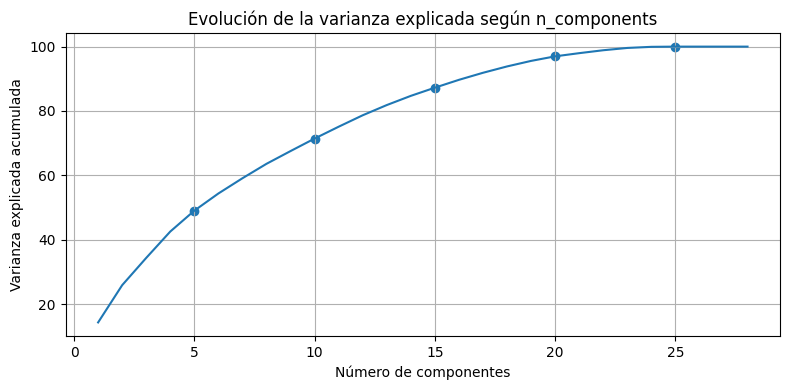

In [80]:
# 1) Transformar X_train con tu preprocesador
X_train_trans = preprocessor.fit_transform(X_train)


# 2) Ajustar PCA con todos los componentes posibles
pca = PCA(random_state=42)
pca.fit(X_train_trans)

# 3) Calcular la varianza explicada acumulada
explained_cumsum = pca.explained_variance_ratio_.cumsum()*100

# 4) Definir los puntos de interés y extraer sus valores
ks = [5, 10, 15, 20, 25]
cums = explained_cumsum[[k-1 for k in ks]]

# 5) Dibujar la curva completa y señalar los ks elegidos
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, len(explained_cumsum) + 1),
    explained_cumsum,
)
plt.scatter(ks, cums)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Evolución de la varianza explicada según n_components')
plt.grid(True)
plt.tight_layout()
plt.show()

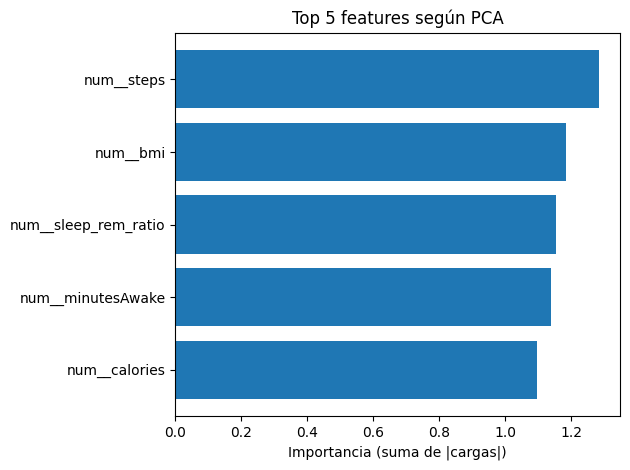

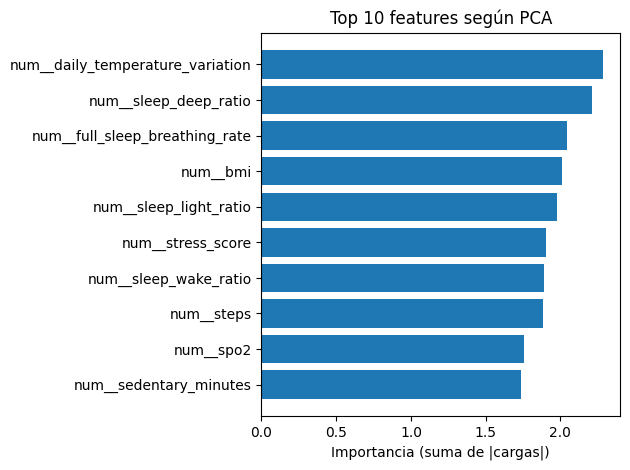

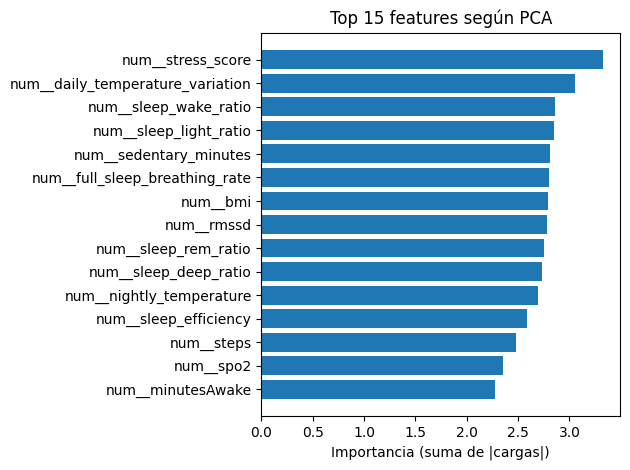

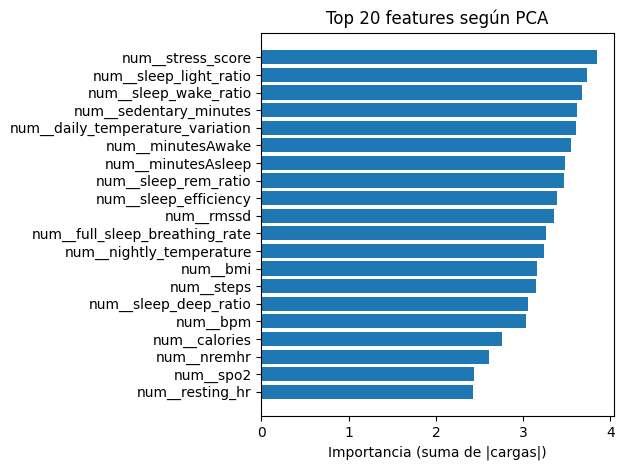

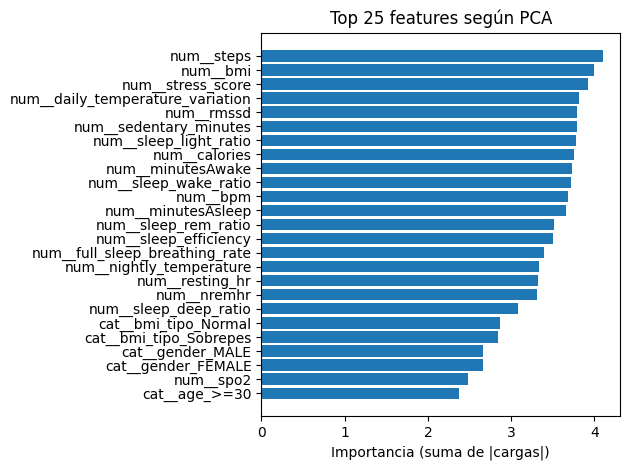

In [81]:
# 1) Nombres de las features resultantes
pca_names = preprocessor.get_feature_names_out()

# 2) Para cada k en [5,10,15,20,25], ajusta un PCA y extrae las importancias
n_components_list = [5, 10, 15, 20, 25]
for k in n_components_list:
    # Ajusta PCA
    pca = PCA(n_components=k, random_state=42)
    pca.fit(X_train_trans)

    # loadings: matriz (n_features, k)
    loadings = pca.components_.T

    # importancia = suma de cargas absolutas de cada feature en todos los componentes
    importance = np.sum(np.abs(loadings), axis=1)

    # crea DataFrame, ordena y toma top-k
    df_imp = pd.DataFrame({
        'feature':    pca_names,
        'importance': importance
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    topk = df_imp.head(k)

    plt.figure()
    plt.barh(topk['feature'][::-1], topk['importance'][::-1])
    plt.xlabel('Importancia (suma de |cargas|)')
    plt.title(f'Top {k} features según PCA')
    plt.tight_layout()
    plt.show()

Aquests gràfics mostren, per cada valor de *k* (5, 10, 15, 20 i 25 components), quines variables original s’aporten més a l’espai de la PCA i, per tant, expliquen més variància del conjunt de dades.

* **Components principals**: són noves variables creades com a combinacions lineals de les variables originals.
* **Càrregues (loadings)**: cada component té un coeficient per a cada variable; aquell coeficient indica quant “pesa” la variable en aquest eix.
* **Importància de la variable**: per a cada variable, sumem el valor absolut de les càrregues als primers *k* components. Una suma més alta vol dir que la variable contribueix de manera rellevant a la variació capturada per aquests *k* eixos.

Així podem veure quines són les *k* variables que més pesen ens diu quins atributs són més informatius (i quins, en canvi, aporten informació redundant).
Els tops *k* ajuden a identificar les característiques més representatives del dataset segons la PCA.


In [ ]:
pca_results = []
pca_models = {}

for target, (y_train, y_test) in TARGETS_SPLIT.items():
    print(f"\n=== PCA experiment pel target: {target} ===")
    pca_models[target] = {}

    for k in n_components_list:
        print(f"\n-- Using PCA with {k} Components --")
        pca_models[target][k] = {}

        for model, classifier in CLASSIFIERS.items():
            pipeline = ImbPipeline([
                ("preprocessor", preprocessor),
                ("smote", SMOTE(random_state=42)),
                ("pca", PCA(n_components=k, random_state=42)), #SMOTE abans que pca
                ("classifier", classifier)
            ])

            current_param_grid = PARAM_GRIDS[model]
            gs = GridSearchCV(
                pipeline, 
                current_param_grid, 
                scoring=f1_cls1,
                cv=cv, 
                n_jobs=-1
            )

            gs.fit(X_train, y_train)

            best_estimator = gs.best_estimator_
            pca_models[target][k][model] = best_estimator

            y_pred = best_estimator.predict(X_test)


            report = classification_report(
            y_test,
            y_pred, # Fem un predict amb el millor model trobat i comparem
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )

            f1_cl1_test = report["1"]["f1-score"]

            pca_results.append({
                "Target":                target,
                "Model":                 model,
                "Experiment":            f'PCA_{k}',
                "Best Params":           gs.best_params_,
                "Best CV F1 (clase 1)":  gs.best_score_,
                "Test Precision (1)":    report["1"]["precision"],
                "Test Recall (1)":       report["1"]["recall"],
                "Test F1 (1)":           f1_cl1_test,
                "Test F1 (macro global)": f1_score(y_test, best_estimator.predict(X_test), average="macro")
            })


            print(f"{model:20s} | Best CV F1(cl1): {gs.best_score_:.4f} | "
              f"Test F1(cl1): {f1_cl1_test:.4f}")





=== PCA experiment pel target: TENSE/ANXIOUS ===

-- Using PCA with 5 Components --
MLP                  | Best CV F1(cl1): 0.3367 | Test F1(cl1): 0.3111
SVM                  | Best CV F1(cl1): 0.3523 | Test F1(cl1): 0.3610
RandomForest         | Best CV F1(cl1): 0.3272 | Test F1(cl1): 0.3177
GradientBoosting     | Best CV F1(cl1): 0.3400 | Test F1(cl1): 0.3491

-- Using PCA with 10 Components --
MLP                  | Best CV F1(cl1): 0.3485 | Test F1(cl1): 0.3604
SVM                  | Best CV F1(cl1): 0.3683 | Test F1(cl1): 0.4053
RandomForest         | Best CV F1(cl1): 0.3583 | Test F1(cl1): 0.3675
GradientBoosting     | Best CV F1(cl1): 0.3484 | Test F1(cl1): 0.3816

-- Using PCA with 15 Components --
MLP                  | Best CV F1(cl1): 0.3511 | Test F1(cl1): 0.2830
SVM                  | Best CV F1(cl1): 0.3672 | Test F1(cl1): 0.3363
RandomForest         | Best CV F1(cl1): 0.3528 | Test F1(cl1): 0.3294
GradientBoosting     | Best CV F1(cl1): 0.3640 | Test F1(cl1): 0.3404

--

In [83]:
pca_results_df = pd.DataFrame(pca_results)
display(pca_results_df[display_cols].round(4))

,Target,Experiment,Model,Best CV F1 (clase 1),Test F1 (1),Test F1 (macro global)
0,TENSE/ANXIOUS,PCA_5,MLP,0.3367,0.3111,0.5116
1,TENSE/ANXIOUS,PCA_5,SVM,0.3523,0.3610,0.4088
2,TENSE/ANXIOUS,PCA_5,RandomForest,0.3272,0.3177,0.5110
3,TENSE/ANXIOUS,PCA_5,GradientBoosting,0.3400,0.3491,0.5349
4,TENSE/ANXIOUS,PCA_10,MLP,0.3485,0.3604,0.5779
5,TENSE/ANXIOUS,PCA_10,SVM,0.3683,0.4053,0.4918
6,TENSE/ANXIOUS,PCA_10,RandomForest,0.3583,0.3675,0.5424
7,TENSE/ANXIOUS,PCA_10,GradientBoosting,0.3484,0.3816,0.5526
8,TENSE/ANXIOUS,PCA_15,MLP,0.3511,0.2830,0.5336
9,TENSE/ANXIOUS,PCA_15,SVM,0.3672,0.3363,0.4732


## EXPERIMENT 3: KNN Imputation

In [ ]:
# 1) Transformers amb KNN per a numèriques
knn_numeric_transformer = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler",  StandardScaler())
])

knn_categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_knn = ColumnTransformer([
    ("num", knn_numeric_transformer, numerical_features),
    ("cat", knn_categorical_transformer, categorical_features)
])

# 2) Entrenament
knn_results = []                
knn_models  = {}                     

for target, (y_train, y_test) in TARGETS_SPLIT.items():
    print(f"\n=== KNN Imputation · Target: {target} ===")
    knn_models[target] = {}
    
    for model, classifier in CLASSIFIERS.items():
        pipe = ImbPipeline([
            ("preprocessor", preprocessor_knn),
            ("smote",        SMOTE(random_state=42)),
            ("classifier",   classifier)
        ])
        
        gs = GridSearchCV(
            pipe,
            PARAM_GRIDS[model],
            scoring=f1_cls1,
            cv=cv,
            n_jobs=-1,
            refit=True
        )
        
        gs.fit(X_train, y_train)
        
        best_est = gs.best_estimator_
        knn_models[target][model] = best_est
        
        y_pred   = best_est.predict(X_test)
        report   = classification_report(
            y_test, y_pred,
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )
        f1_cl1_test = report["1"]["f1-score"]
        macro_f1    = f1_score(y_test, y_pred, average="macro")
        
        knn_results.append({
            "Target":                target,
            "Experiment":            "KNN_Imputation",
            "Model":                 model,
            "Best Params":           gs.best_params_,
            "Best CV F1 (clase 1)":  round(gs.best_score_, 4),
            "Test Precision (1)":    round(report["1"]["precision"], 4),
            "Test Recall (1)":       round(report["1"]["recall"], 4),
            "Test F1 (1)":           round(f1_cl1_test, 4),
            "Test F1 (macro global)":       round(macro_f1, 4)
        })
        
        print(f"{model:20s} | Best CV F1(cl1): {gs.best_score_:.4f} | "
              f"Test F1(cl1): {f1_cl1_test:.4f}")
        



=== KNN Imputation · Target: TENSE/ANXIOUS ===
MLP                  | Best CV F1(cl1): 0.3298 | Test F1(cl1): 0.3070
SVM                  | Best CV F1(cl1): 0.3665 | Test F1(cl1): 0.3357
RandomForest         | Best CV F1(cl1): 0.3585 | Test F1(cl1): 0.3212
GradientBoosting     | Best CV F1(cl1): 0.3281 | Test F1(cl1): 0.2947

=== KNN Imputation · Target: TIRED ===
MLP                  | Best CV F1(cl1): 0.4429 | Test F1(cl1): 0.5316
SVM                  | Best CV F1(cl1): 0.4884 | Test F1(cl1): 0.5091
RandomForest         | Best CV F1(cl1): 0.4588 | Test F1(cl1): 0.4665
GradientBoosting     | Best CV F1(cl1): 0.4321 | Test F1(cl1): 0.5040


In [86]:
# 3) DataFrame resum
knn_df = pd.DataFrame(knn_results)

display(knn_df[display_cols_perm].round(4))

,Target,Experiment,Model,Best CV F1 (clase 1),Test F1 (1),Test F1 (macro)
0,TENSE/ANXIOUS,KNN_Imputation,MLP,0.3298,0.3070,0.5472
1,TENSE/ANXIOUS,KNN_Imputation,SVM,0.3665,0.3357,0.5170
2,TENSE/ANXIOUS,KNN_Imputation,RandomForest,0.3585,0.3212,0.5700
3,TENSE/ANXIOUS,KNN_Imputation,GradientBoosting,0.3281,0.2947,0.5551
4,TIRED,KNN_Imputation,MLP,0.4429,0.5316,0.5997
5,TIRED,KNN_Imputation,SVM,0.4884,0.5091,0.5766
6,TIRED,KNN_Imputation,RandomForest,0.4588,0.4665,0.5736
7,TIRED,KNN_Imputation,GradientBoosting,0.4321,0.5040,0.5785


## EXPERIMENT 4: Target Row augmententation

In [ ]:
# ------------------------------------------------------------------
# 0) Paràmetres i conjunts auxiliars
# ------------------------------------------------------------------
# f1_cls1 ja està definit a l'script global:
# f1_cls1 = make_scorer(f1_score, pos_label=1)

df_missing_targets = df_null_targets.copy()
X_missing_targets  = df_missing_targets.drop(columns=TARGETS)
print("Shape of features with missing targets:", X_missing_targets.shape)

# ------------------------------------------------------------------
# 1) Pseudo‑labels a partir del millor model KNN (segons F1 classe 1)
# ------------------------------------------------------------------
pseudo_labels = {}
if not knn_models:
    print("No hi ha models KNN. S'omet l'experiment.")
else:
    for target in TARGETS:
        print(f"\nGenerant pseudo-labels per a {target} …")
        best_row = knn_df[knn_df["Target"] == target] \
                     .sort_values("Test F1 (1)", ascending=False) \
                     .head(1)
        if best_row.empty:
            print("  Resultats KNN buits; omès.")
            pseudo_labels[target] = None
            continue

        best_name  = best_row["Model"].iloc[0]
        best_model = knn_models[target][best_name]
        pseudo_labels[target] = best_model.predict(X_missing_targets)
        print(f"  {len(pseudo_labels[target])} pseudo-labels generades amb {best_name}")

# ------------------------------------------------------------------
# 2) Concatenem dades i re‑entrenem
# ------------------------------------------------------------------
target_aug_results = []
target_aug_models  = {}

if all(pseudo_labels.get(t) is not None for t in TARGETS):
    X_train_aug = pd.concat([X_train, X_missing_targets], ignore_index=True)
    y_tense_aug = pd.concat([y_tense_train,
                             pd.Series(pseudo_labels["TENSE/ANXIOUS"])],
                            ignore_index=True)
    y_tired_aug = pd.concat([y_tired_train,
                             pd.Series(pseudo_labels["TIRED"])],
                            ignore_index=True)

    AUG_TARGETS = {
        "TENSE/ANXIOUS": (y_tense_aug, y_tense_test),
        "TIRED":         (y_tired_aug,  y_tired_test)
    }
    print("\nTrain augmentat:", X_train_aug.shape)

    for tarfet, (y_train_aug, y_test) in AUG_TARGETS.items():
        print(f"\n=== Retraining on augmented data · {target} ===")
        target_aug_models[target] = {}

        for name, clf in CLASSIFIERS.items():
            pipe = ImbPipeline([
                ("preprocessor", preprocessor_knn),   # KNN imputació consistent
                ("smote",        SMOTE(random_state=42)),
                ("classifier",   clf)
            ])

            gs = GridSearchCV(
                pipe,
               PARAM_GRIDS[name],
                scoring=f1_cls1,     
                cv=cv,
                n_jobs=-1,
                refit=True
            ).fit(X_train_aug, y_train_aug)

            best_est = gs.best_estimator_
            target_aug_models[target][name] = best_est

            y_pred   = best_est.predict(X_test)
            f1_cl1   = f1_score(y_test, y_pred, pos_label=1)
            macro_f1 = f1_score(y_test, y_pred, average="macro")
            report   = classification_report(
                y_test, y_pred,
                labels=[0, 1],
                output_dict=True,
                zero_division=0
            )

            target_aug_results.append({
                "Target":                target,
                "Experiment":            "Target_Augmentation",
                "Model":                 name,
                "Best Params":           gs.best_params_,
                "Best CV F1 (1)":        round(gs.best_score_, 4),
                "Test Precision (1)":    round(report["1"]["precision"], 4),
                "Test Recall (1)":       round(report["1"]["recall"], 4),
                "Test F1 (1)":           round(f1_cl1, 4),
                "Test F1 (macro global)":       round(macro_f1, 4)
            })

            print(f"{name:15s}  CV F1(cl1)={gs.best_score_: .4f}  "
                  f"Test F1(cl1)={f1_cl1:.4f}")
else:
    print("\nPseudo-labels mancants en algun target. Experiment omès.")



Shape of features with missing targets: (5120, 23)

Generant pseudo‑labels per a TENSE/ANXIOUS …
  5120 pseudo-labels generades amb SVM

Generant pseudo‑labels per a TIRED …
  5120 pseudo-labels generades amb MLP

Train augmentat: (6952, 23)

=== Retraining on augmented data · TENSE/ANXIOUS ===
MLP              CV F1(cl1)= 0.7904  Test F1(cl1)=0.2419
SVM              CV F1(cl1)= 0.8097  Test F1(cl1)=0.3636
RandomForest     CV F1(cl1)= 0.7803  Test F1(cl1)=0.2526
GradientBoosting  CV F1(cl1)= 0.7936  Test F1(cl1)=0.3172

=== Retraining on augmented data · TIRED ===
MLP              CV F1(cl1)= 0.7335  Test F1(cl1)=0.5143
SVM              CV F1(cl1)= 0.7391  Test F1(cl1)=0.5363
RandomForest     CV F1(cl1)= 0.7190  Test F1(cl1)=0.4753
GradientBoosting  CV F1(cl1)= 0.7202  Test F1(cl1)=0.5072


In [92]:
# ------------------------------------------------------------------
# 3) DataFrame resum final
# ------------------------------------------------------------------
aug_df = pd.DataFrame(target_aug_results)
display_cols_aug = ['Target', 'Experiment', 'Model', 'Best CV F1 (1)', 'Test F1 (1)', 'Test F1 (macro global)']
display(aug_df[display_cols_aug].round(4))



,Target,Experiment,Model,Best CV F1 (1),Test F1 (1),Test F1 (macro global)
0,TENSE/ANXIOUS,Target_Augmentation,MLP,0.7904,0.2419,0.5047
1,TENSE/ANXIOUS,Target_Augmentation,SVM,0.8097,0.3636,0.5604
2,TENSE/ANXIOUS,Target_Augmentation,RandomForest,0.7803,0.2526,0.5285
3,TENSE/ANXIOUS,Target_Augmentation,GradientBoosting,0.7936,0.3172,0.5461
4,TIRED,Target_Augmentation,MLP,0.7335,0.5143,0.5811
5,TIRED,Target_Augmentation,SVM,0.7391,0.5363,0.5893
6,TIRED,Target_Augmentation,RandomForest,0.7190,0.4753,0.5941
7,TIRED,Target_Augmentation,GradientBoosting,0.7202,0.5072,0.6033


## Anàlisi de resultats

In [97]:
# --- Results Compilation ---
all_results_dfs = [base_results_df]
if 'feature_importance_results_df' in locals() and not feature_importance_results_df.empty: all_results_dfs.append(feature_importance_results_df)
if 'perm_topk_results_df' in locals() and not perm_topk_results_df.empty: all_results_dfs.append(perm_topk_results_df)
if 'pca_results_df' in locals() and not pca_results_df.empty: all_results_dfs.append(pca_results_df)
if 'knn_imputation_results_df' in locals() and not knn_df.empty: all_results_dfs.append(knn_df)
if 'target_augmentation_results_df' in locals() and not aug_df.empty: all_results_dfs.append(aug_df)

if len(all_results_dfs) > 1:
    combined_results_df = pd.concat(all_results_dfs, ignore_index=True)
    print("\nCombined results from all experiments.")
else:
    print("\nOnly baseline results available.")
    combined_results_df = base_results_df

ordered_cols = ["Target", "Experiment", "Model", "Test F1 (1)", "Test Precision (1)", "Test Recall (1)","Best Params"]
final_cols = [col for col in ordered_cols if col in combined_results_df.columns]
combined_results_df = combined_results_df[final_cols]

# --- Analysis ---
print("\n--- Overall Performance Analysis (Sorted by Test F1-Macro) ---")
combined_results_sorted = combined_results_df.sort_values(
    by=["Target", "Test F1 (1)"], ascending=[True, False]
).reset_index(drop=True)

print("\nTop Performing Models/Experiments per Target:")
for target_name in combined_results_sorted["Target"].unique():
    print(f"\n--- Target: {target_name} ---")
    top_results_target = combined_results_sorted[combined_results_sorted["Target"] == target_name]
    display_cols_summary = ["Experiment", "Model", "Test F1 (1)", "Test Precision (1)", "Test Recall (1)"]
    display(top_results_target[display_cols_summary].head().round(4))


Combined results from all experiments.

--- Overall Performance Analysis (Sorted by Test F1-Macro) ---

Top Performing Models/Experiments per Target:

--- Target: TENSE/ANXIOUS ---


,Experiment,Model,Test F1 (1),Test Precision (1),Test Recall (1)
0,Top_15_Permutation,RandomForest,0.4771,0.4444,0.5149
1,Top_10_Permutation,RandomForest,0.4603,0.3986,0.5446
2,Top_15_Permutation,GradientBoosting,0.4320,0.3624,0.5347
3,Entrenament basic,RandomForest,0.4239,0.4699,0.3861
4,Top_10_Features,GradientBoosting,0.4215,0.3852,0.4653



--- Target: TIRED ---


,Experiment,Model,Test F1 (1),Test Precision (1),Test Recall (1)
40,PCA_15,SVM,0.5635,0.5021,0.6421
41,Top_10_Permutation,SVM,0.5634,0.5085,0.6316
42,PCA_10,SVM,0.5602,0.5000,0.6368
43,Top_15_Features,MLP,0.5574,0.5795,0.5368
44,Entrenament basic,GradientBoosting,0.5561,0.5652,0.5474



=== TENSE/ANXIOUS | Top_15_Permutation | RandomForest ===


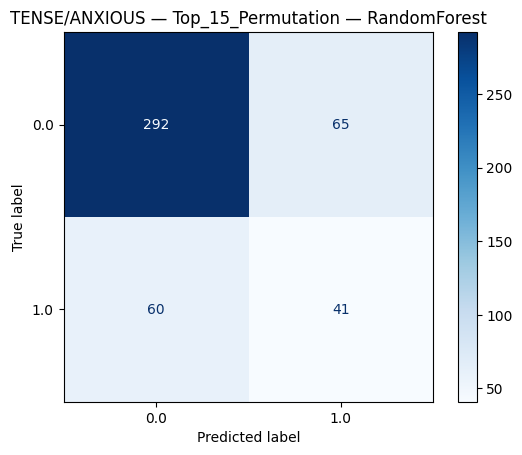


=== TENSE/ANXIOUS | Top_10_Permutation | RandomForest ===


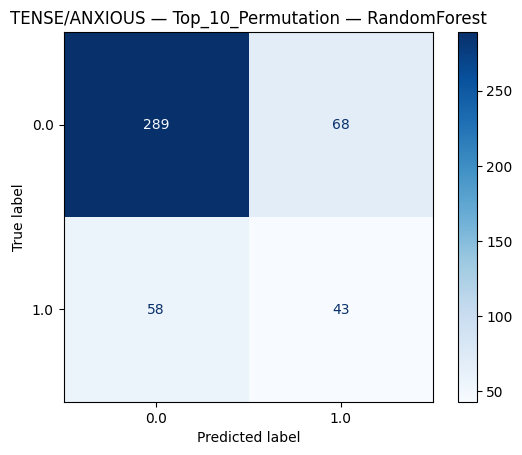


=== TENSE/ANXIOUS | Top_15_Permutation | GradientBoosting ===


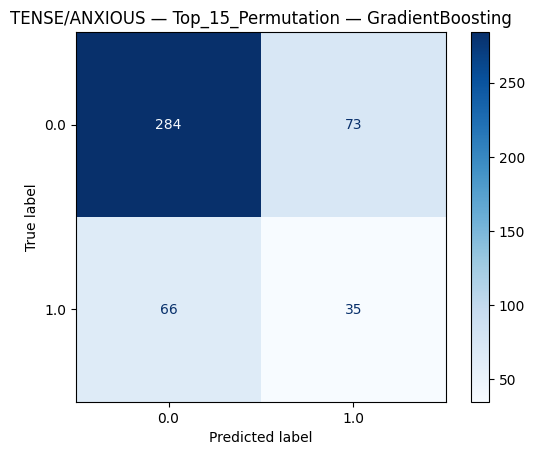


=== TENSE/ANXIOUS | Entrenament basic | RandomForest ===


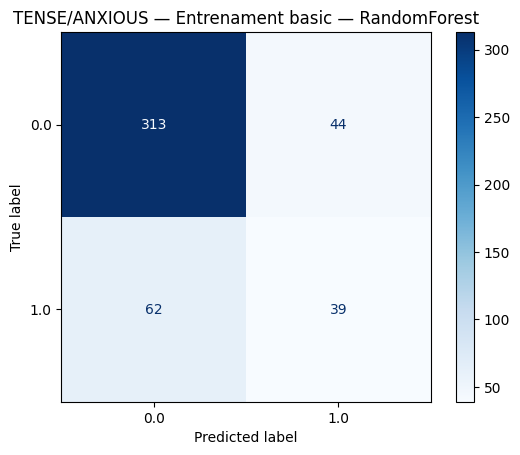


=== TENSE/ANXIOUS | Top_10_Features | GradientBoosting ===


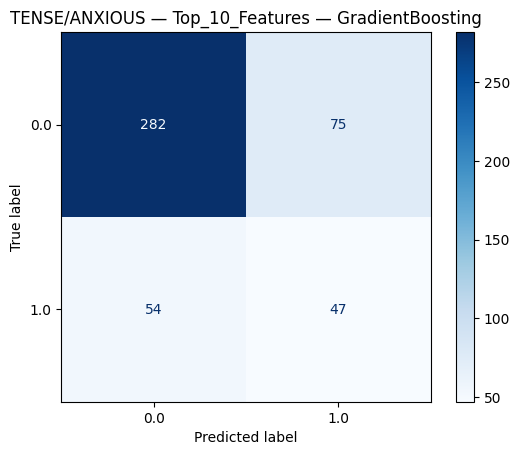


=== TIRED | PCA_15 | SVM ===


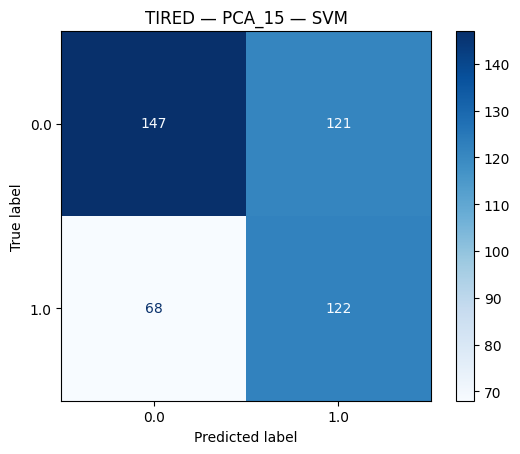


=== TIRED | Top_10_Permutation | SVM ===


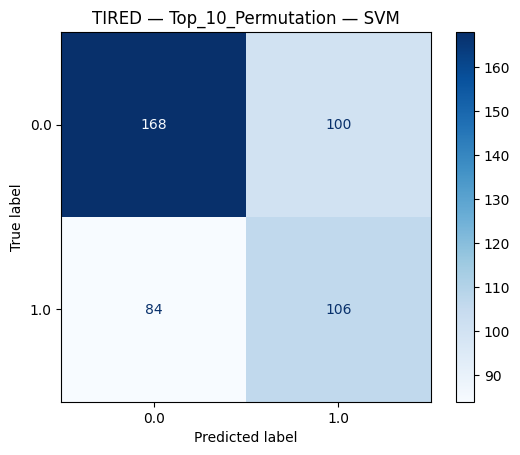


=== TIRED | PCA_10 | SVM ===


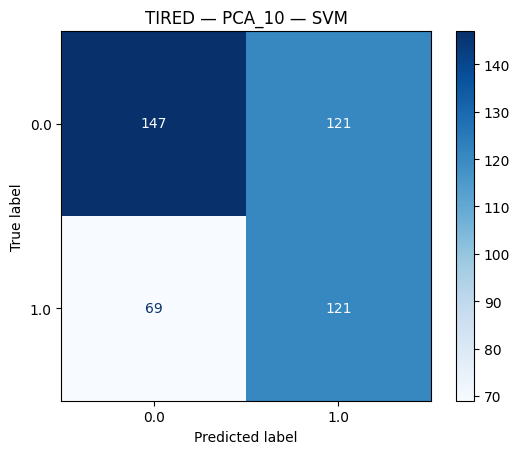


=== TIRED | Top_15_Features | MLP ===


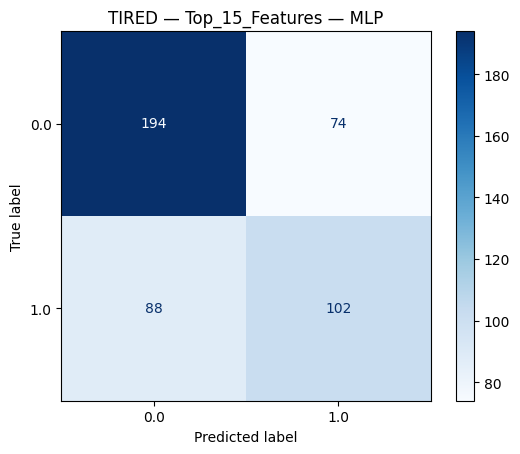


=== TIRED | Entrenament basic | GradientBoosting ===


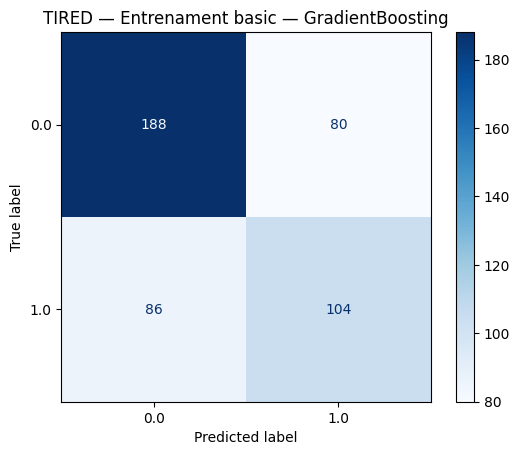

In [100]:
# Mapeig dels test sets per cada target
test_sets = {
    "TENSE/ANXIOUS": (X_test, y_tense_test),
    "TIRED":          (X_test, y_tired_test)
}

# Per cada target, agafa les 5 millors (ja que combined_results_sorted està ordenat descendent per Test F1-Macro)
for target in combined_results_sorted["Target"].unique():
    top5 = combined_results_sorted[
        combined_results_sorted["Target"] == target
    ].head(5)

    for _, row in top5.iterrows():
        experiment = row["Experiment"]
        model_name = row["Model"]

        print(f"\n=== {target} | {experiment} | {model_name} ===")

        # Selecciona el model segons l'experiment
        if experiment == "Entrenament basic":
            model = base_models[target][model_name]
        elif experiment.startswith("Top_"):
            n = int(experiment.split("_")[1])
            model = fi_models[target][n][model_name]
        elif experiment.startswith("PCA_"):
            n = int(experiment.split("_")[1])
            model = pca_models[target][n][model_name]
        elif experiment == "KNN_Imputation":
            model = knn_models[target][model_name]
        elif experiment == "Target_Augmentation":
            model = target_aug_models[target][model_name]
        else:
            raise ValueError(f"Experiment desconegut: {experiment}")

        # Prepara dades de test i prediccions
        X_test_target, y_true = test_sets[target]
        y_pred = model.predict(X_test_target)

        # Calcula i mostra la matriu de confusió
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=model.classes_)
        disp.plot(cmap="Blues")
        plt.title(f"{target} — {experiment} — {model_name}")
        plt.show()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Millor CV F1(cl1): 0.5209
Millors paràmetres: {'mlp__activation': 'logistic', 'mlp__alpha': np.float64(0.009637199770892528), 'mlp__batch_size': 32, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (183, 139, 60), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': np.float64(0.002025488643009626), 'mlp__n_iter_no_change': 10, 'mlp__solver': 'adam', 'mlp__tol': 1e-05}
Llindar òptim: 0.506

=== Informe TEST ===
              precision    recall  f1-score   support

         0.0     0.6429    0.6045    0.6231       268
         1.0     0.4854    0.5263    0.5051       190

    accuracy                         0.5721       458
   macro avg     0.5641    0.5654    0.5641       458
weighted avg     0.5776    0.5721    0.5741       458



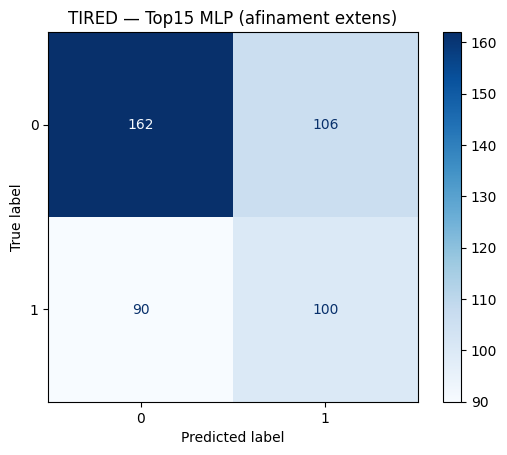

In [107]:
# ------------------------------------------------------------------
# 0) Paquet i dades Top‑15 (ja calculades)
# ------------------------------------------------------------------
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, make_scorer
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# llista de 15 millors features (Gini o permutació, la que vulguis)
sel_feats   = perm_top_features["TIRED"][15]        # o perm_top_features["TIRED"][15]
num_sel = [f for f in sel_feats if f in numerical_features]
cat_sel = [f for f in sel_feats if f in categorical_features]

transfs = []
if num_sel:
    transfs.append(("num", numeric_transformer, num_sel))
if cat_sel:
    transfs.append(("cat", categorical_transformer, cat_sel))
preproc_top = ColumnTransformer(transfs)

# train_in / val per llindar
X_tr_in, X_val, y_tr_in, y_val = train_test_split(
    X_train, y_tired_train,
    test_size=0.20, stratify=y_tired_train, random_state=42
)

# ------------------------------------------------------------------
# 1) Pipeline
# ------------------------------------------------------------------
pipe = ImbPipeline([
    ("preprocessor", preproc_top),
    ("smote",        SMOTE(random_state=42)),
    ("mlp",          MLPClassifier(max_iter=1500, random_state=42))
])

# ------------------------------------------------------------------
# 2) Hiperparàmetres (distribucions àmplies)
# ------------------------------------------------------------------
from scipy.stats import uniform, randint

param_dist = {
    "mlp__hidden_layer_sizes": [(randint.rvs(50, 250),),               # 1 capa
                                (randint.rvs(80, 200), randint.rvs(30,120)),  # 2 capes
                                (randint.rvs(100, 200), randint.rvs(70,140), randint.rvs(20,70))],   # 3
    "mlp__activation":         ["relu", "tanh", "logistic"],
    "mlp__solver":             ["adam", "lbfgs"],
    "mlp__alpha":              uniform(1e-6, 1e-2),      # 1e‑6 → 1e‑2
    "mlp__learning_rate":      ["constant", "adaptive"],
    "mlp__learning_rate_init": uniform(1e-4, 5e-3),      # 1e‑4 → 5e‑3
    "mlp__batch_size":         [32, 64, 128, 256],
    "mlp__early_stopping":     [True],
    "mlp__tol":                [1e-4, 1e-5],
    "mlp__n_iter_no_change":   [10, 20]
}

f1_cls1 = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ------------------------------------------------------------------
# 3) RandomizedSearch (100 configs → 5 × 100 = 500 fits)
# ------------------------------------------------------------------
rs = RandomizedSearchCV(
    pipe, param_dist, n_iter=100,
    scoring=f1_cls1, cv=cv, n_jobs=-1, refit=True,
    verbose=2, random_state=42
).fit(X_tr_in, y_tr_in)

best_mlp = rs.best_estimator_
print("Millor CV F1(cl1):", round(rs.best_score_, 4))
print("Millors paràmetres:", rs.best_params_)

# ------------------------------------------------------------------
# 4) Llindar òptim (F1 macro) sobre VALIDATION
# ------------------------------------------------------------------
probs_val = best_mlp.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, probs_val)
f1_macro_vals = [f1_score(y_val, (probs_val>=t), average="macro") for t in thr]
thr_opt = thr[int(np.argmax(f1_macro_vals))]
print(f"Llindar òptim: {thr_opt:.3f}")

# ------------------------------------------------------------------
# 5) TEST final
# ------------------------------------------------------------------
probs_test = best_mlp.predict_proba(X_test)[:, 1]
y_pred = (probs_test >= thr_opt).astype(int)

print("\n=== Informe TEST ===")
print(classification_report(y_tired_test, y_pred, digits=4))

cm = ConfusionMatrixDisplay.from_predictions(y_tired_test, y_pred, labels=[0,1], cmap="Blues")
cm.ax_.set_title("TIRED — Top15 MLP (afinament extens)")
plt.show()


In [ ]:
X = df_complete.drop(columns=TARGET)
y = df_complete['TIRED']

print("Tipus de y:", y.dtype)
print("Valors únics:", y.unique())  # mostra només els 20 primers si n'hi ha molts
print(y.value_counts())

# Train / Test Split
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"\nDistribució train:\n{y_train.value_counts(normalize=True)}")
print(f"\nDistribució test:\n{y_test.value_counts(normalize=True)}")

Tipus de y: float64
Valors únics: [1. 0.]
TIRED
0.0    1410
1.0     880
Name: count, dtype: int64

Train shape: (1832, 23)
Test shape: (458, 23)

Distribució train:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64

Distribució test:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64


In [ ]:
X = df_complete.drop(columns=TARGET)
y = df_complete['TIRED']

print("Tipus de y:", y.dtype)
print("Valors únics:", y.unique())  # mostra només els 20 primers si n'hi ha molts
print(y.value_counts())

# Train / Test Split
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"\nDistribució train:\n{y_train.value_counts(normalize=True)}")
print(f"\nDistribució test:\n{y_test.value_counts(normalize=True)}")

Tipus de y: float64
Valors únics: [1. 0.]
TIRED
0.0    1410
1.0     880
Name: count, dtype: int64

Train shape: (1832, 23)
Test shape: (458, 23)

Distribució train:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64

Distribució test:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64
